# Визначення аномального навантаження на сервери

Ви зібрали логи роботи віртуальних машин у датацентрі, які знімалися протягом певного часу з певною періодичністю. Логи складаються з записів навантаження на CPU та об’єму використаної оперативної пам’яті (RAM).

У цьому завданні ви визначите незвично малі/великі навантаження за допомогою Gaussian Mixture Model. Для вивчення гаусіан ви реалізуєте алгоритм Expectation Maximization.

При правильній реалізації алгоритму, функція log-likelihood буде зростати з кожною EM-ітерацією і дійде до збіжності.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math

In [2]:
from matplotlib.patches import Ellipse

In [3]:
%matplotlib inline

## Налаштування

Файл із логами споживання ресурсів.

In [4]:
input_filename = "system-load.csv"

Кількість гаусіан, які ми будемо вивчати.

In [5]:
num_gaussians = 3

Максимальна кількість ітерацій EM-алгоритму.

In [6]:
max_em_iterations = 300

Поріг збіжності log-likelihood функції (для ранньої зупинки EM-алгоритму).

In [7]:
convergence_eps = 0.01

Стан генератора випадкових чисел.

In [8]:
random_seed = 42

## Завантаження даних

In [9]:
df_load = pd.read_csv(input_filename)

In [10]:
X = df_load.values

Щоб забезпечити збіжність і числову стабільність алгоритму, приведемо всі ознаки до діапазону [0..1].

In [11]:
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [12]:
m, n = X.shape

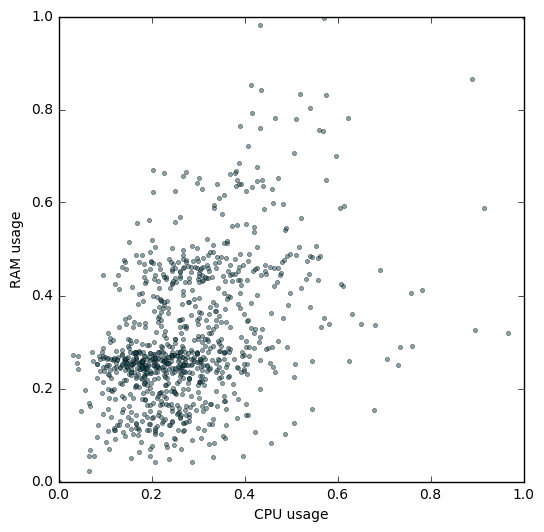

In [13]:
plt.figure(figsize=(6, 6))
plt.plot(X.T[0], X.T[1], "o", c="#144C59", alpha=0.5, markersize=3)

plt.xlabel("CPU usage")
plt.ylabel("RAM usage")
plt.show()

## Навчання GMM

In [14]:
np.random.seed(random_seed)

Ініціалізуємо центри гаусіан випадковими навчальними прикладами.

In [15]:
means = X[np.random.choice(m, size=num_gaussians, replace=False)]

Ініціалізуємо матриці коваріацій кожної гаусіани одиничними матрицями.

In [16]:
covariances = np.ones((num_gaussians, n, n)) * np.identity(n)

Апріорі, кожна гаусіана матиме рівну ймовірність покриття точок.

In [17]:
phis = np.ones(num_gaussians) / num_gaussians

Ініціалізуємо матрицю ймовірностей належності точок.

In [18]:
W = np.zeros((num_gaussians, m))

Реалізуйте функцію густини багатовимірного нормального розподілу:

$ P(x; \mu, \Sigma) = \frac{1}{(2 \pi)^{n/2} |\Sigma|^{1/2}} \exp \left(-\frac{1}{2} (x-\mu)^\top \Sigma^{-1} (x-\mu) \right) $

In [19]:
def multivariate_gaussian_pdf(X, mu, sigma):
    # library 
    # y = multivariate_normal.pdf(X, mean=mu, cov=sigma)
    
    y = [];
    for x in X:
        size = len(x)
        det = np.linalg.det(sigma)
        norm_const = 1.0/( math.pow((2*math.pi),float(size)/2) * math.pow(det,1.0/2) )
        x_mu = np.matrix(x - mu)
        inv = np.matrix(sigma).I        
        result = math.pow(math.e, -0.5 * (x_mu * inv * x_mu.T))
        y.append(norm_const * result)
    return np.asarray(y)

Реалізуйте крок E алгоритму EM:

$ w_j^{(i)} = P(x^{(i)}; \mu_j, \Sigma_j) \cdot \phi_j $

In [20]:
def e_step(X, means, covariances, phis):
    W = []
    for i in np.arange(num_gaussians):
        probability = multivariate_gaussian_pdf(X, means[i], covariances[i])*phis[i];
        W.append(probability)
    return W

Реалізуйте крок M алгоритму EM:

$\phi_j = \frac{1}{m} \sum_{i=1}^{m}{w_j^{(i)}}$

$\mu_j = \frac{\sum_{i=1}^{m}{w_j^{(i)} x^{(i)}}}{\sum_{i=1}^{m}{w_j^{(i)}}}$

$\Sigma_j = \frac{\sum_{i=1}^{m}{w_j^{(i)} (x^{(i)} - \mu_j)(x^{(i)} - \mu_j)^\top}}{\sum_{i=1}^{m}{w_j^{(i)}}}$

In [21]:
def m_step(X, W):
    num_gaussians = len(W)
    m, n = X.shape
    
    phis = []
    means = []
    covariances = []
    
    for j in np.arange(num_gaussians):
        # compute phis
        phis.append(np.sum(W[j])/len(X))

        # compute means
        mu = [0, 0]
        for n, x in enumerate(X):
            mu = (mu + np.dot(X[n],W[j][n]))
        means.append(mu/np.sum(W[j]))
        
        # compute covariances
        cov_top = [[0, 0],[0, 0]]
        for n, x in enumerate(X):
            cov_top = cov_top + W[j][n]*(X[n]-means[j])*np.transpose((X[n]-means[j])[np.newaxis])
        covariances.append(cov_top/np.sum(W[j]))
        
    return np.asarray(phis), np.asarray(means), np.asarray(covariances)

**Виконуємо EM-ітерації до збіжності**

In [22]:
def gmm_log_likelihood(W):
    return np.sum(np.log(np.sum(W, axis=0)))

In [23]:
log_likelihoods = []

In [24]:
for iteration in range(max_em_iterations):
    # E-step.
    W = e_step(X, means, covariances, phis)

    # Compute log-likelihood.
    log_likelihood = gmm_log_likelihood(W)
    log_likelihoods.append(log_likelihood)
    print("Iteration: {0:3d}    Log-likelihood: {1:10.4f}".format(iteration, log_likelihood))

    # Normalize W so that it's row-stochastic.
    W = W / np.sum(W, axis=0)

    # M-step.
    phis, means, covariances = m_step(X, W)
    
    # Check log-likelihood for convergence.
    if len(log_likelihoods) > 2 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < convergence_eps:
        print("EM has converged. Stopping early.")
        break

Iteration:   0    Log-likelihood: -1792.4863
Iteration:   1    Log-likelihood:  1126.1728
Iteration:   2    Log-likelihood:  1147.6845
Iteration:   3    Log-likelihood:  1196.3866
Iteration:   4    Log-likelihood:  1239.3713
Iteration:   5    Log-likelihood:  1263.4331
Iteration:   6    Log-likelihood:  1274.2707
Iteration:   7    Log-likelihood:  1278.8859
Iteration:   8    Log-likelihood:  1280.9282
Iteration:   9    Log-likelihood:  1281.8832
Iteration:  10    Log-likelihood:  1282.3662
Iteration:  11    Log-likelihood:  1282.6470
Iteration:  12    Log-likelihood:  1282.8473
Iteration:  13    Log-likelihood:  1283.0233
Iteration:  14    Log-likelihood:  1283.2026
Iteration:  15    Log-likelihood:  1283.4005
Iteration:  16    Log-likelihood:  1283.6280
Iteration:  17    Log-likelihood:  1283.8964
Iteration:  18    Log-likelihood:  1284.2206
Iteration:  19    Log-likelihood:  1284.6236
Iteration:  20    Log-likelihood:  1285.1417
Iteration:  21    Log-likelihood:  1285.8318
Iteration:

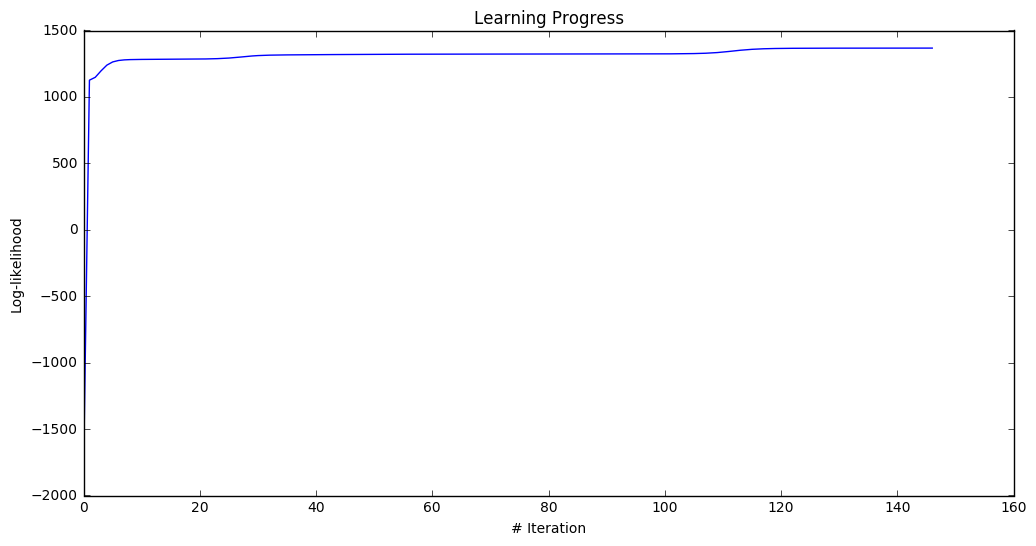

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods)

plt.xlabel("# Iteration")
plt.ylabel("Log-likelihood")
plt.title("Learning Progress")

plt.show()

## Візуалізація результатів

In [26]:
def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    width, height = 2 * nstd * np.sqrt(abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [27]:
def plot_gaussians(X, means, covs, ax=None):
    n = len(means)
    colors = ["#1F77B4", "#2CA02C", "#FFBB78", "#4C529B"]
    
    plt.cla()
    plt.plot(X.T[0], X.T[1], "o", c="#144C59", alpha=0.5, markersize=3)
    
    for k in range(num_gaussians):
        plot_ellipse(means[k], covs[k], ax=ax, alpha=0.4, color=colors[k % len(colors)])

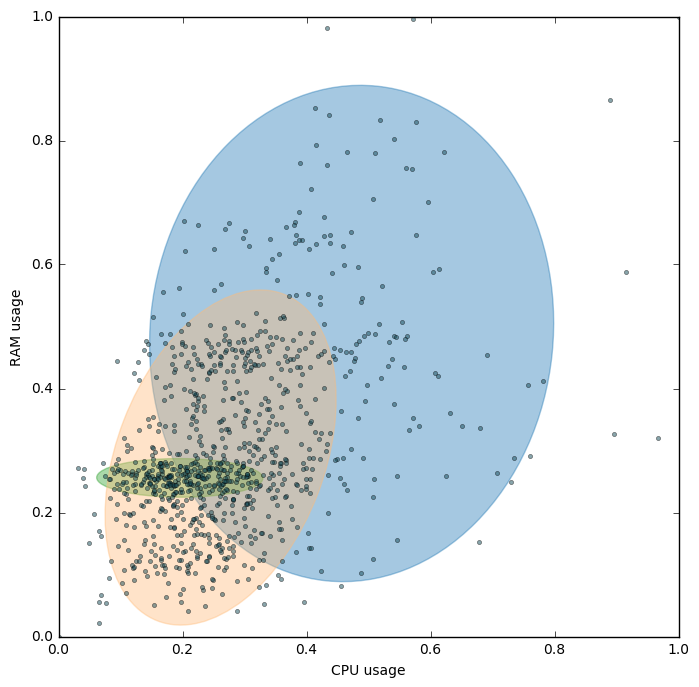

In [28]:
plt.figure(figsize=(8, 8))
plot_gaussians(X, means, covariances)

plt.xlabel("CPU usage")
plt.ylabel("RAM usage")
plt.show()